# Preserving values equal or greater to zero with safeguards: Example on precipitation from observations and reanalysis 

This example explores the effects of three different lossy compressors (ZFP, SZ3, SPERR) on a time series (3 days, hourly intervals) of precipitation `PR` from observations and the corresponding closest grid point in the reanalysis product ERA5. The compressors are applied to either time series of the individual observations or the global grid of ERA5. Finally, we apply safeguards to guarantee an absolute error bound and values are equal or greater than zero.  

The meteorological relevant properties of `PR` we study are the magnitude of the maximum, the integral over the time series, occurrences of precipitation (including false positives and negatives), and occurrences of negative values.


In [1]:
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Retrieve the data
Belem = pd.read_csv(Path() / "data" / "obs-pr" / "belem.csv")
Helsinki = pd.read_csv(Path() / "data" / "obs-pr" / "helsinki.csv")
ERA5 = xr.open_dataset(Path() / "data" / "era5-pr" / "data.nc")

In [ ]:
# Extract the data variables
Time = ERA5["valid_time"].data
ERA5_PR = ERA5["tp"] * 1000 # ERA5 precipitation is stored in meters, convert to mm (1 m -> 1000 mm)
Belem_PR = Belem["PR"]
Helsinki_PR = Helsinki["PR"]

In [4]:
ERA5_Belem_PR = ERA5_PR.sel(
    latitude=-1.4563, longitude=360 - 48.5013, method="nearest"
).data
ERA5_Helsinki_PR = ERA5_PR.sel(
    latitude=60.1699, longitude=24.9384, method="nearest"
).data

In [5]:
ERA5_PR.shape, Belem_PR.shape, Helsinki_PR.shape

((72, 721, 1440), (72,), (72,))

In [6]:
def plot_positive_precipitation(pr, ax, y, c):
    foox = []
    fooy = []
    lastx = None
    wasgap = pr[0] <= 0.0

    for t, p in zip(Time, pr):
        if p > 0.0:
            if wasgap:
                wasgap = False
                foox.append(t - (t - lastx) / 2)
            else:
                foox.append(t)
            fooy.append(y)
        else:
            if not wasgap:
                wasgap = True
                foox.append(t - (t - lastx) / 2)
                fooy.append(y)
                ax.plot(foox, fooy, lw=2, c=c, solid_capstyle="butt")
                foox = []
                fooy = []
        lastx = t

    if len(foox) > 0:
        ax.plot(foox, fooy, lw=2, c=c, solid_capstyle="butt")

In [7]:
def plot_negative_precipitation(pr, ax, y):
    foox = []
    fooy = []
    lastx = None
    wasgap = pr[0] >= 0.0

    for t, p in zip(Time, pr):
        if p < 0.0:
            if wasgap:
                wasgap = False
                foox.append(t - (t - lastx) / 2)
            else:
                foox.append(t)
            fooy.append(y)
        else:
            if not wasgap:
                wasgap = True
                foox.append(t - (t - lastx) / 2)
                fooy.append(y)
                ax.plot(foox, fooy, lw=4, c="red", solid_capstyle="butt")
                foox = []
                fooy = []
        lastx = t

    if len(foox) > 0:
        ax.plot(foox, fooy, lw=4, c="red", solid_capstyle="butt")

In [8]:
def extract_and_plot(
    my_ERA5_PR: xr.DataArray,
    my_ERA5_PR_cr: float,
    my_Belem_PR: pd.DataFrame,
    my_Belem_PR_cr: float,
    my_Helsinki_PR: pd.DataFrame,
    my_Helsinki_PR_cr: float,
    title: str,
):
    my_ERA5_Belem_PR = my_ERA5_PR.sel(
        latitude=-1.4563, longitude=360 - 48.5013, method="nearest"
    ).data
    my_ERA5_Helsinki_PR = my_ERA5_PR.sel(
        latitude=60.1699, longitude=24.9384, method="nearest"
    ).data

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.set_title(
        f"{title}\n"
        + rf"$L_{{{{\infty}}}}(\hat{{{{PR}}}})$={np.amax(np.abs(my_ERA5_PR - ERA5_PR)):.02}   x {np.round(my_ERA5_PR_cr, 2)}"
    )
    ax2.set_title(
        "\n"
        + rf"$L_{{{{\infty}}}}(\hat{{{{PR}}}})$={np.amax(np.abs(my_Helsinki_PR - Helsinki_PR)):.02}   x {np.round(my_Helsinki_PR_cr, 2)}"
        + "     "
        + rf"$L_{{{{\infty}}}}(\hat{{{{PR}}}})$={np.amax(np.abs(my_Belem_PR - Belem_PR)):.02}   x {np.round(my_Belem_PR_cr, 2)}"
    )

    pos = mdates.HourLocator(byhour=(0, 6, 12, 18))
    fmt = mdates.DateFormatter("%d-%m %Hh")

    bf = ax1.fill_between(
        Time,
        my_ERA5_Belem_PR,
        alpha=0.5,
        label=f"Integral: {np.format_float_positional(100 * (np.sum(my_ERA5_Belem_PR) - np.sum(ERA5_Belem_PR)) / np.sum(ERA5_Belem_PR), precision=1, min_digits=1, sign=True)}%",
    )
    hf = ax1.fill_between(
        Time,
        my_ERA5_Helsinki_PR,
        alpha=0.5,
        label=f"Integral: {np.format_float_positional(100 * (np.sum(my_ERA5_Helsinki_PR) - np.sum(ERA5_Helsinki_PR)) / np.sum(ERA5_Helsinki_PR), precision=1, min_digits=1, sign=True)}%",
    )

    bp = ax1.plot(Time, my_ERA5_Belem_PR, ls=(0, (1, 1)))
    hp = ax1.plot(Time, my_ERA5_Helsinki_PR, ls=(0, (1, 1)))

    ax1.axhline(-1.5, c="black", lw=1)
    ax1.text(
        Time[0] + (Time[-1] - Time[0]) / 2,
        -3.75,
        "Time periods with non-zero precipitation:",
        ha="center",
        va="center",
    )

    plot_positive_precipitation(my_ERA5_Belem_PR, ax1, -7.5, bp[0].get_c())
    plot_negative_precipitation(my_ERA5_Belem_PR, ax1, -7.5)
    plot_positive_precipitation(my_ERA5_Helsinki_PR, ax1, -6, hp[0].get_c())
    plot_negative_precipitation(my_ERA5_Helsinki_PR, ax1, -6)

    bpp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=2,
        c=bp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.format_float_positional(100 * (np.sum(my_ERA5_Belem_PR > 0) - np.sum(ERA5_Belem_PR > 0)) / np.sum(ERA5_Belem_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    bfp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_ERA5_Belem_PR > 0) != (ERA5_Belem_PR > 0)), precision=1, min_digits=1)}%",
    )
    bnp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.format_float_positional(100 * np.mean(my_ERA5_Belem_PR < 0), precision=1, min_digits=1)}%",
    )
    hpp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=2,
        c=hp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.format_float_positional(100 * (np.sum(my_ERA5_Helsinki_PR > 0) - np.sum(ERA5_Helsinki_PR > 0)) / np.sum(ERA5_Helsinki_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    hfp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_ERA5_Helsinki_PR > 0) != (ERA5_Helsinki_PR > 0)), precision=1, min_digits=1)}%",
    )
    hnp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.format_float_positional(100 * np.mean(my_ERA5_Helsinki_PR < 0), precision=1, min_digits=1)}%",
    )

    bm = ax1.scatter(
        [Time[np.argmax(my_ERA5_Belem_PR)]],
        [np.amax(my_ERA5_Belem_PR)],
        marker="o",
        facecolors="none",
        edgecolors=bp[0].get_c(),
        label=f"Max: {np.format_float_positional((Time[np.argmax(my_ERA5_Belem_PR)] - Time[np.argmax(ERA5_Belem_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_ERA5_Belem_PR) - np.amax(ERA5_Belem_PR), precision=2, min_digits=2, sign=True)}mm",
    )
    hm = ax1.scatter(
        [Time[np.argmax(my_ERA5_Helsinki_PR)]],
        [np.amax(my_ERA5_Helsinki_PR)],
        marker="o",
        facecolors="none",
        edgecolors=hp[0].get_c(),
        label=f"Max: {np.format_float_positional((Time[np.argmax(my_ERA5_Helsinki_PR)] - Time[np.argmax(ERA5_Helsinki_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_ERA5_Helsinki_PR) - np.amax(ERA5_Helsinki_PR), precision=2, min_digits=2, sign=True)}mm",
    )

    ax1.set_ylabel("ERA5 Precipitation (mm / 1h)")
    ax1.xaxis.set(major_locator=pos, major_formatter=fmt)
    ax1.set_xlim(Time.min(), Time.max())
    ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=30, ha="right")
    ax1.set_ylim(-9, 30)
    ax1.set_yticks([0, 5, 10, 15, 20, 25])

    l1 = ax1.legend(
        handles=[hm, hf, *hpp, *hfp, *hnp], loc="upper left", title="Helsinki, Finland"
    )
    ax1.legend(
        handles=[bm, bf, *bpp, *bfp, *bnp], loc="upper right", title="Belem, Brazil"
    )
    ax1.add_artist(l1)

    bf = ax2.fill_between(
        Time,
        my_Belem_PR,
        alpha=0.5,
        label=f"Integral: {np.format_float_positional(100 * (np.sum(my_Belem_PR) - np.sum(Belem_PR)) / np.sum(Belem_PR), precision=1, min_digits=1, sign=True)}%",
    )
    hf = ax2.fill_between(
        Time,
        my_Helsinki_PR,
        alpha=0.5,
        label=f"Integral: {np.format_float_positional(100 * (np.sum(my_Helsinki_PR) - np.sum(Helsinki_PR)) / np.sum(Helsinki_PR), precision=1, min_digits=1, sign=True)}%",
    )

    bp = ax2.plot(Time, my_Belem_PR, ls=(0, (1, 1)))
    hp = ax2.plot(Time, my_Helsinki_PR, ls=(0, (1, 1)))

    ax2.axhline(-1.5, c="black", lw=1)
    ax2.text(
        Time[0] + (Time[-1] - Time[0]) / 2,
        -3.75,
        "Time periods with non-zero precipitation:",
        ha="center",
        va="center",
    )

    plot_positive_precipitation(my_Belem_PR, ax2, -7.5, bp[0].get_c())
    plot_negative_precipitation(my_Belem_PR, ax2, -7.5)
    plot_positive_precipitation(my_Helsinki_PR, ax2, -6, hp[0].get_c())
    plot_negative_precipitation(my_Helsinki_PR, ax2, -6)

    bpp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=2,
        c=bp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.format_float_positional(100 * (np.sum(my_Belem_PR > 0) - np.sum(Belem_PR > 0)) / np.sum(Belem_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    bfp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_Belem_PR > 0) != (Belem_PR > 0)), precision=1, min_digits=1)}%",
    )
    bnp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.format_float_positional(100 * np.mean(my_Belem_PR < 0), precision=1, min_digits=1)}%",
    )
    hpp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=2,
        c=hp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.format_float_positional(100 * (np.sum(my_Helsinki_PR > 0) - np.sum(Helsinki_PR > 0)) / np.sum(Helsinki_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    hfp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_Helsinki_PR > 0) != (Helsinki_PR > 0)), precision=1, min_digits=1)}%",
    )
    hnp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.format_float_positional(100 * np.mean(my_Helsinki_PR < 0), precision=1, min_digits=1)}%",
    )

    bm = ax2.scatter(
        [Time[np.argmax(my_Belem_PR)]],
        [np.amax(my_Belem_PR)],
        marker="o",
        facecolors="none",
        edgecolors=bp[0].get_c(),
        label=f"Max: {np.format_float_positional((Time[np.argmax(my_Belem_PR)] - Time[np.argmax(Belem_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_Belem_PR) - np.amax(Belem_PR), precision=2, min_digits=2, sign=True)}mm",
    )
    hm = ax2.scatter(
        [Time[np.argmax(my_Helsinki_PR)]],
        [np.amax(my_Helsinki_PR)],
        marker="o",
        facecolors="none",
        edgecolors=hp[0].get_c(),
        label=f"Max: {np.format_float_positional((Time[np.argmax(my_Helsinki_PR)] - Time[np.argmax(Helsinki_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_Helsinki_PR) - np.amax(Helsinki_PR), precision=2, min_digits=2, sign=True)}mm",
    )

    ax2.set_ylabel("Precipitation Observations (mm / 1h)")
    ax2.xaxis.set(major_locator=pos, major_formatter=fmt)
    ax2.set_xlim(Time.min(), Time.max())
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=30, ha="right")
    ax2.set_ylim(-9, 30)
    ax2.set_yticks([0, 5, 10, 15, 20, 25])

    l1 = ax2.legend(
        handles=[hm, hf, *hpp, *hfp, *hnp], loc="upper left", title="Helsinki, Finland"
    )
    ax2.legend(
        handles=[bm, bf, *bpp, *bfp, *bnp], loc="upper right", title="Belem, Brazil"
    )
    ax2.add_artist(l1)

    plt.tight_layout()

    plt.show()

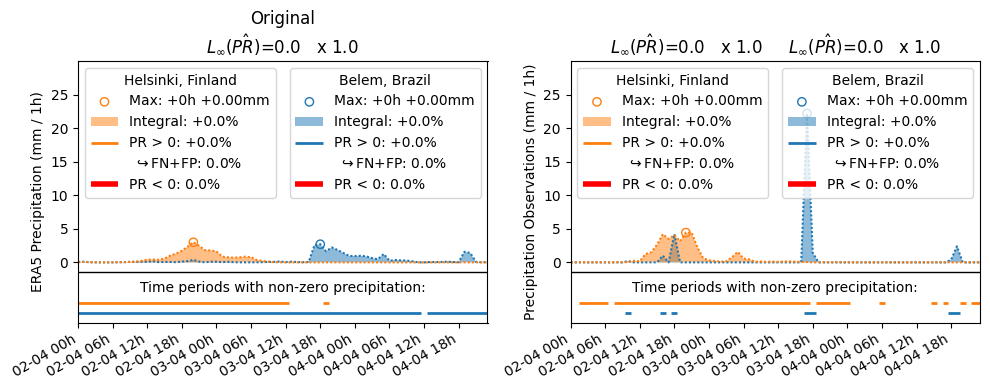

In [9]:
extract_and_plot(ERA5_PR, 1.0, Belem_PR, 1.0, Helsinki_PR, 1.0, "Original")

## Compressing precipitation with lossy 

In [10]:
from numcodecs_wasm_sperr import Sperr
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_zfp import Zfp

In [11]:
def encode_decode(codec):
    ERA5_PR_codec_enc = codec.encode(ERA5_PR.values)
    ERA5_PR_codec = ERA5_PR.copy(data=codec.decode(ERA5_PR_codec_enc))
    ERA5_PR_codec_cr = ERA5_PR.nbytes / ERA5_PR_codec_enc.nbytes

    Belem_PR_codec = Belem_PR.copy(deep=True)
    Belem_PR_codec_enc = codec.encode(Belem_PR_codec.values)
    Belem_PR_codec.values[:] = codec.decode(Belem_PR_codec_enc)
    Belem_PR_codec_cr = Belem_PR.nbytes / Belem_PR_codec_enc.nbytes

    Helsinki_PR_codec = Helsinki_PR.copy(deep=True)
    Helsinki_PR_codec_enc = codec.encode(Helsinki_PR_codec.values)
    Helsinki_PR_codec.values[:] = codec.decode(Helsinki_PR_codec_enc)
    Helsinki_PR_codec_cr = Helsinki_PR.nbytes / Helsinki_PR_codec_enc.nbytes

    return (
        ERA5_PR_codec,
        ERA5_PR_codec_cr,
        Belem_PR_codec,
        Belem_PR_codec_cr,
        Helsinki_PR_codec,
        Helsinki_PR_codec_cr,
    )

In [12]:
eb_abs = 0.1

In [13]:
zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)
(
    ERA5_PR_zfp,
    ERA5_PR_zfp_cr,
    Belem_PR_zfp,
    Belem_PR_zfp_cr,
    Helsinki_PR_zfp,
    Helsinki_PR_zfp_cr,
) = encode_decode(zfp)

In [14]:
sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)
(
    ERA5_PR_sz3,
    ERA5_PR_sz3_cr,
    Belem_PR_sz3,
    Belem_PR_sz3_cr,
    Helsinki_PR_sz3,
    Helsinki_PR_sz3_cr,
) = encode_decode(sz3)

In [15]:
sperr = Sperr(mode="pwe", pwe=eb_abs)
(
    ERA5_PR_sperr,
    ERA5_PR_sperr_cr,
    Belem_PR_sperr,
    Belem_PR_sperr_cr,
    Helsinki_PR_sperr,
    Helsinki_PR_sperr_cr,
) = encode_decode(sperr)

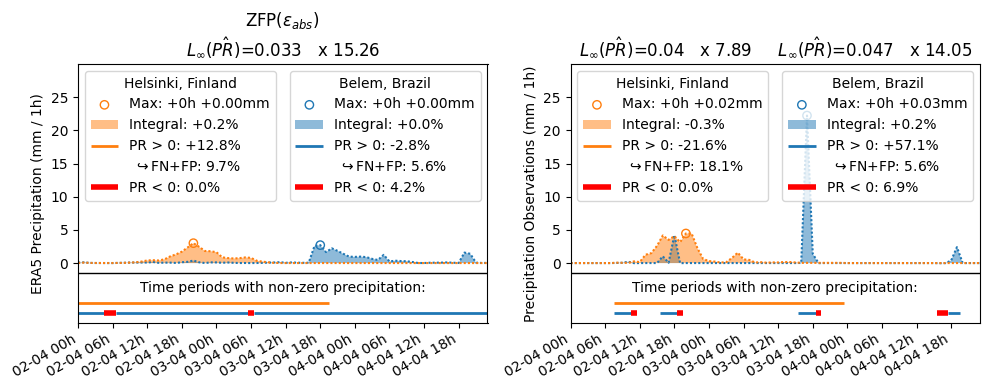

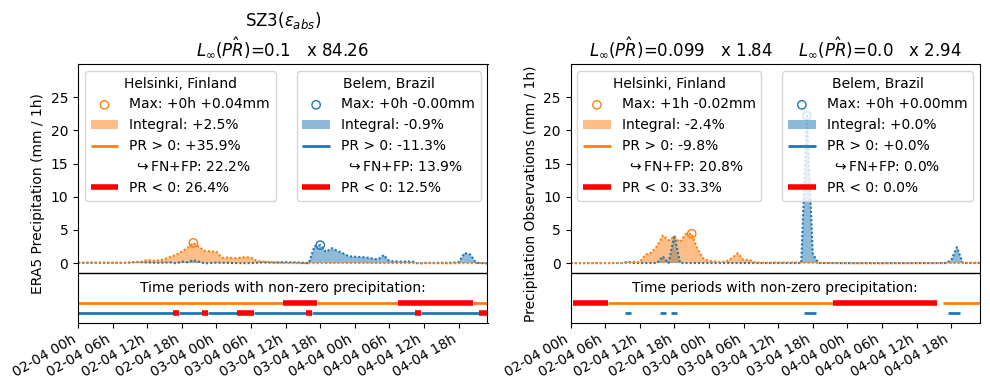

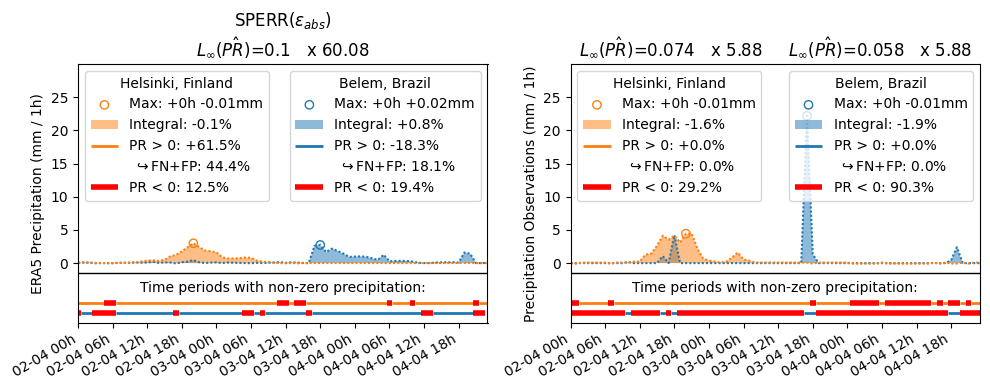

In [16]:
extract_and_plot(
    ERA5_PR_zfp,
    ERA5_PR_zfp_cr,
    Belem_PR_zfp,
    Belem_PR_zfp_cr,
    Helsinki_PR_zfp,
    Helsinki_PR_zfp_cr,
    r"ZFP($\epsilon_{{abs}}$)",
)
extract_and_plot(
    ERA5_PR_sz3,
    ERA5_PR_sz3_cr,
    Belem_PR_sz3,
    Belem_PR_sz3_cr,
    Helsinki_PR_sz3,
    Helsinki_PR_sz3_cr,
    r"SZ3($\epsilon_{{abs}}$)",
)
extract_and_plot(
    ERA5_PR_sperr,
    ERA5_PR_sperr_cr,
    Belem_PR_sperr,
    Belem_PR_sperr_cr,
    Helsinki_PR_sperr,
    Helsinki_PR_sperr_cr,
    r"SPERR($\epsilon_{{abs}}$)",
)

## Compressing precipitation with safeguarded lossy compression

In [17]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

In [18]:
ERA5_PR_sg = dict()
ERA5_PR_sg_cr = dict()

for codec in [ZeroCodec(), zfp, sz3, sperr]:
    sg_era5 = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(kind="eb", type="abs", eb=0.1),
            dict(kind="sign"),
            dict(kind="sign", offset=np.amax(ERA5_Belem_PR)),
            dict(kind="sign", offset=np.amax(ERA5_Helsinki_PR)),
        ],
    )

    ERA5_PR_sg_enc = sg_era5.encode(ERA5_PR.values)
    ERA5_PR_sg[codec.codec_id] = ERA5_PR.copy(data=sg_era5.decode(ERA5_PR_sg_enc))
    ERA5_PR_sg_cr[codec.codec_id] = ERA5_PR.nbytes / np.asarray(ERA5_PR_sg_enc).nbytes

In [19]:
Belem_PR_sg = dict()
Belem_PR_sg_cr = dict()

Helsinki_PR_sg = dict()
Helsinki_PR_sg_cr = dict()

for codec in [ZeroCodec(), zfp, sz3, sperr]:
    sg_obs = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(kind="eb", type="abs", eb=0.1),
            dict(kind="sign"),
            # we only want to preserve *the* global maximum
            dict(kind="sign", offset="$x_max"),
        ],
    )

    Belem_PR_sg[codec.codec_id] = Belem_PR.copy(deep=True)
    Belem_PR_sg_enc = sg_obs.encode(Belem_PR_sg[codec.codec_id].values)
    Belem_PR_sg[codec.codec_id].values[:] = sg_obs.decode(Belem_PR_sg_enc)
    Belem_PR_sg_cr[codec.codec_id] = (
        Belem_PR.nbytes / np.asarray(Belem_PR_sg_enc).nbytes
    )

    Helsinki_PR_sg[codec.codec_id] = Helsinki_PR.copy(deep=True)
    Helsinki_PR_sg_enc = sg_obs.encode(Helsinki_PR_sg[codec.codec_id].values)
    Helsinki_PR_sg[codec.codec_id].values[:] = sg_obs.decode(Helsinki_PR_sg_enc)
    Helsinki_PR_sg_cr[codec.codec_id] = (
        Helsinki_PR.nbytes / np.asarray(Helsinki_PR_sg_enc).nbytes
    )

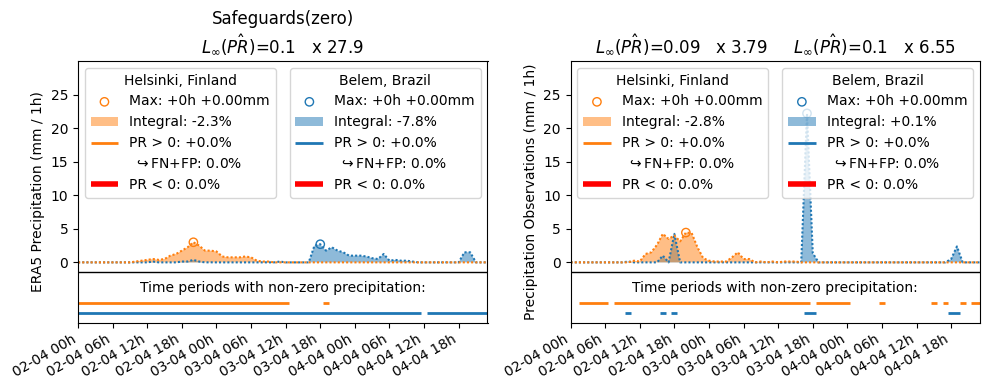

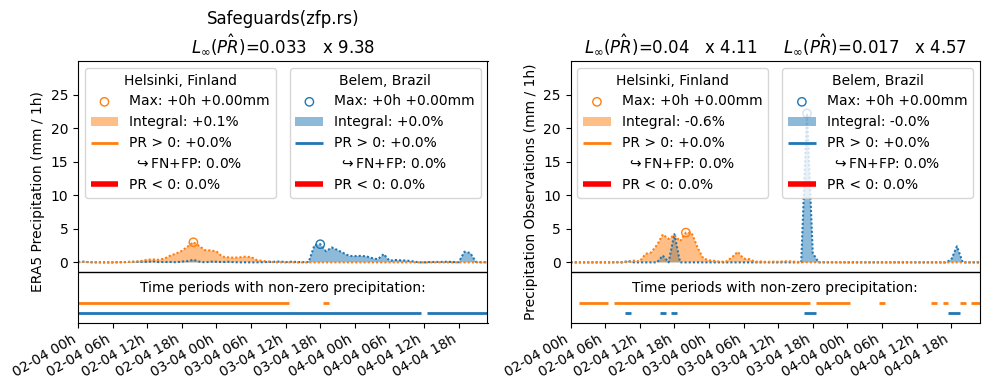

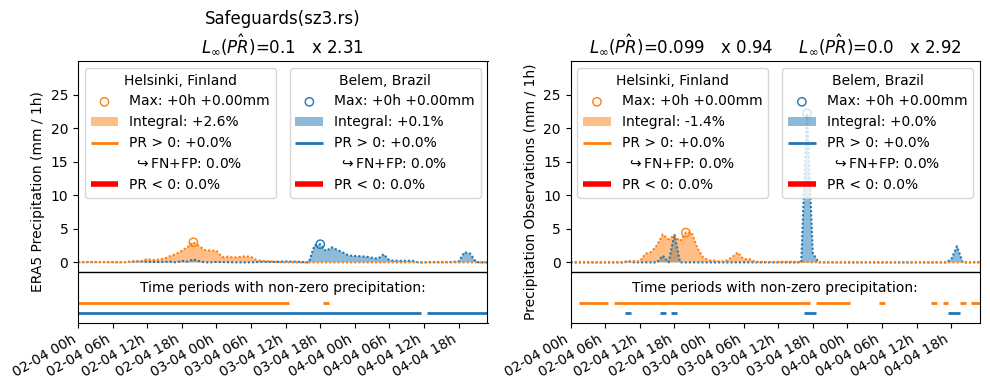

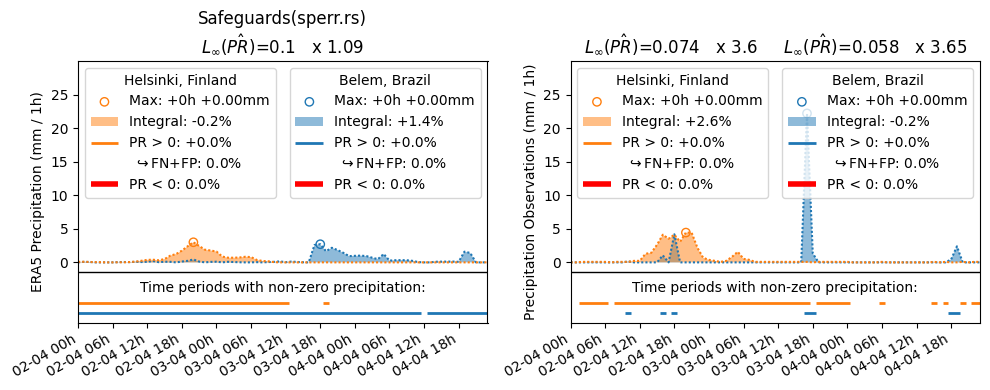

In [20]:
for codec_id in Belem_PR_sg:
    extract_and_plot(
        ERA5_PR_sg[codec_id],
        ERA5_PR_sg_cr[codec_id],
        Belem_PR_sg[codec_id],
        Belem_PR_sg_cr[codec_id],
        Helsinki_PR_sg[codec_id],
        Helsinki_PR_sg_cr[codec_id],
        f"Safeguards({codec_id})",
    )